Importing the Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.metrics import accuracy_score,confusion_matrix

In [2]:
#Reading the dataset
df = pd.read_csv('Air_Index.csv',encoding='unicode_escape')

print("---Dataset Overview---")
df.info()

print("\n---Missing Values Count---")
print(df.isnull().sum())


---Dataset Overview---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3228 entries, 0 to 3227
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   country        3228 non-null   object 
 1   state          3228 non-null   object 
 2   city           3228 non-null   object 
 3   station        3228 non-null   object 
 4   last_update    3228 non-null   object 
 5   latitude       3228 non-null   float64
 6   longitude      3228 non-null   float64
 7   pollutant_id   3228 non-null   object 
 8   pollutant_min  3057 non-null   float64
 9   pollutant_max  3057 non-null   float64
 10  pollutant_avg  3057 non-null   float64
dtypes: float64(5), object(6)
memory usage: 277.5+ KB

---Missing Values Count---
country            0
state              0
city               0
station            0
last_update        0
latitude           0
longitude          0
pollutant_id       0
pollutant_min    171
pollutant_max    171
pollut

In [3]:
df.shape

(3228, 11)

In [4]:
# 1. Pivot the table so each pollutant becomes a column
# We take the 'pollutant_avg' value for each pollutant type
df_pivot = df.pivot_table(values='pollutant_avg',
                          index=['state', 'city', 'station', 'last_update'],
                          columns='pollutant_id').reset_index()

# 2. Fill any new NaN values created by the pivot (where a station didn't measure a specific gas)
df_pivot.fillna(0, inplace=True)

# 3. Check your new structure
print("--- New Dataset with Pollutant Columns ---")
print(df_pivot.head())
print("\n--- New Column Names ---")
print(df_pivot.columns)

--- New Dataset with Pollutant Columns ---
pollutant_id           state               city  \
0             Andhra_Pradesh          Amaravati   
1             Andhra_Pradesh          Anantapur   
2             Andhra_Pradesh           Chittoor   
3             Andhra_Pradesh             Kadapa   
4             Andhra_Pradesh  Rajamahendravaram   

pollutant_id                                         station  \
0                             Secretariat, Amaravati - APPCB   
1                               Gulzarpet, Anantapur - APPCB   
2                        Gangineni Cheruvu, Chittoor - APPCB   
3                            Yerramukkapalli, Kadapa - APPCB   
4             Anand Kala Kshetram, Rajamahendravaram - APPCB   

pollutant_id          last_update    CO  NH3   NO2  OZONE   PM10  PM2.5   SO2  
0             26-01-2026 19:00:00  12.0  5.0  20.0   61.0  149.0  155.0   7.0  
1             26-01-2026 19:00:00  24.0  5.0  14.0   13.0   70.0   68.0  11.0  
2             26-01-2026 

In [5]:
print("--- Missing Values Before Cleaning ---")
print(df_pivot.isnull().sum())

# Fill missing values using Forward Fill (ffill)
df_pivot.fillna(method='ffill', inplace=True)

# Fill any remaining NaNs with the median of numeric columns only
numeric_cols = df_pivot.select_dtypes(include=np.number).columns
df_pivot[numeric_cols] = df_pivot[numeric_cols].fillna(df_pivot[numeric_cols].median())

print("\n--- Missing Values After Cleaning ---")
print(df_pivot.isnull().sum())

--- Missing Values Before Cleaning ---
pollutant_id
state          0
city           0
station        0
last_update    0
CO             0
NH3            0
NO2            0
OZONE          0
PM10           0
PM2.5          0
SO2            0
dtype: int64

--- Missing Values After Cleaning ---
pollutant_id
state          0
city           0
station        0
last_update    0
CO             0
NH3            0
NO2            0
OZONE          0
PM10           0
PM2.5          0
SO2            0
dtype: int64


In [6]:
df_pivot['last_update'] = pd.to_datetime(df_pivot['last_update'])
df_pivot['hour'] = df_pivot['last_update'].dt.hour
df_pivot['day_of_week'] = df_pivot['last_update'].dt.dayofweek

le = LabelEncoder()
df_pivot['state_code'] = le.fit_transform(df_pivot['state'])
df_pivot['city_code'] = le.fit_transform(df_pivot['city'])


print("--- Features Ready for Training ---")
print(df_pivot[['state_code', 'city_code', 'hour', 'PM2.5', 'PM10']].head())

--- Features Ready for Training ---
pollutant_id  state_code  city_code  hour  PM2.5   PM10
0                      0          7    19  155.0  149.0
1                      0         11    19   68.0   70.0
2                      0         67    19   75.0   69.0
3                      0        121    19   64.0   64.0
4                      0        194    19   93.0  103.0


In [7]:
df_pivot.describe(include='all')

pollutant_id,state,city,station,last_update,CO,NH3,NO2,OZONE,PM10,PM2.5,SO2,hour,day_of_week,state_code,city_code
count,481,481,481,481,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.000000,481.0,481.0,481.000000,481.000000
unique,29,249,481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Maharashtra,Delhi,"Ward-32 Bapupara, Siliguri - WBPCB",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,85,39,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2026-01-26 19:00:00,35.006237,5.357588,31.166320,46.197505,106.345114,112.540541,13.717256,19.0,0.0,14.962578,118.465696
min,NaN,NaN,NaN,2026-01-26 19:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.0,0.0,0.000000,0.000000
25%,NaN,NaN,NaN,2026-01-26 19:00:00,21.000000,1.000000,12.000000,16.000000,70.000000,56.000000,5.000000,19.0,0.0,8.000000,72.000000
50%,NaN,NaN,NaN,2026-01-26 19:00:00,32.000000,4.000000,26.000000,34.000000,108.000000,98.000000,11.000000,19.0,0.0,15.000000,110.000000
75%,NaN,NaN,NaN,2026-01-26 19:00:00,46.000000,8.000000,43.000000,64.000000,143.000000,155.000000,18.000000,19.0,0.0,22.000000,172.000000
max,NaN,NaN,NaN,2026-01-26 19:00:00,109.000000,33.000000,290.000000,297.000000,454.000000,354.000000,102.000000,19.0,0.0,28.000000,248.000000


In [8]:
df_pivot.nunique()

,0
pollutant_id,
state,29
city,249
station,481
last_update,1
CO,91
NH3,25
NO2,96
OZONE,131
PM10,175


In [9]:
df_pivot.columns

Index(['state', 'city', 'station', 'last_update', 'CO', 'NH3', 'NO2', 'OZONE',
       'PM10', 'PM2.5', 'SO2', 'hour', 'day_of_week', 'state_code',
       'city_code'],
      dtype='object', name='pollutant_id')

Data Visualization

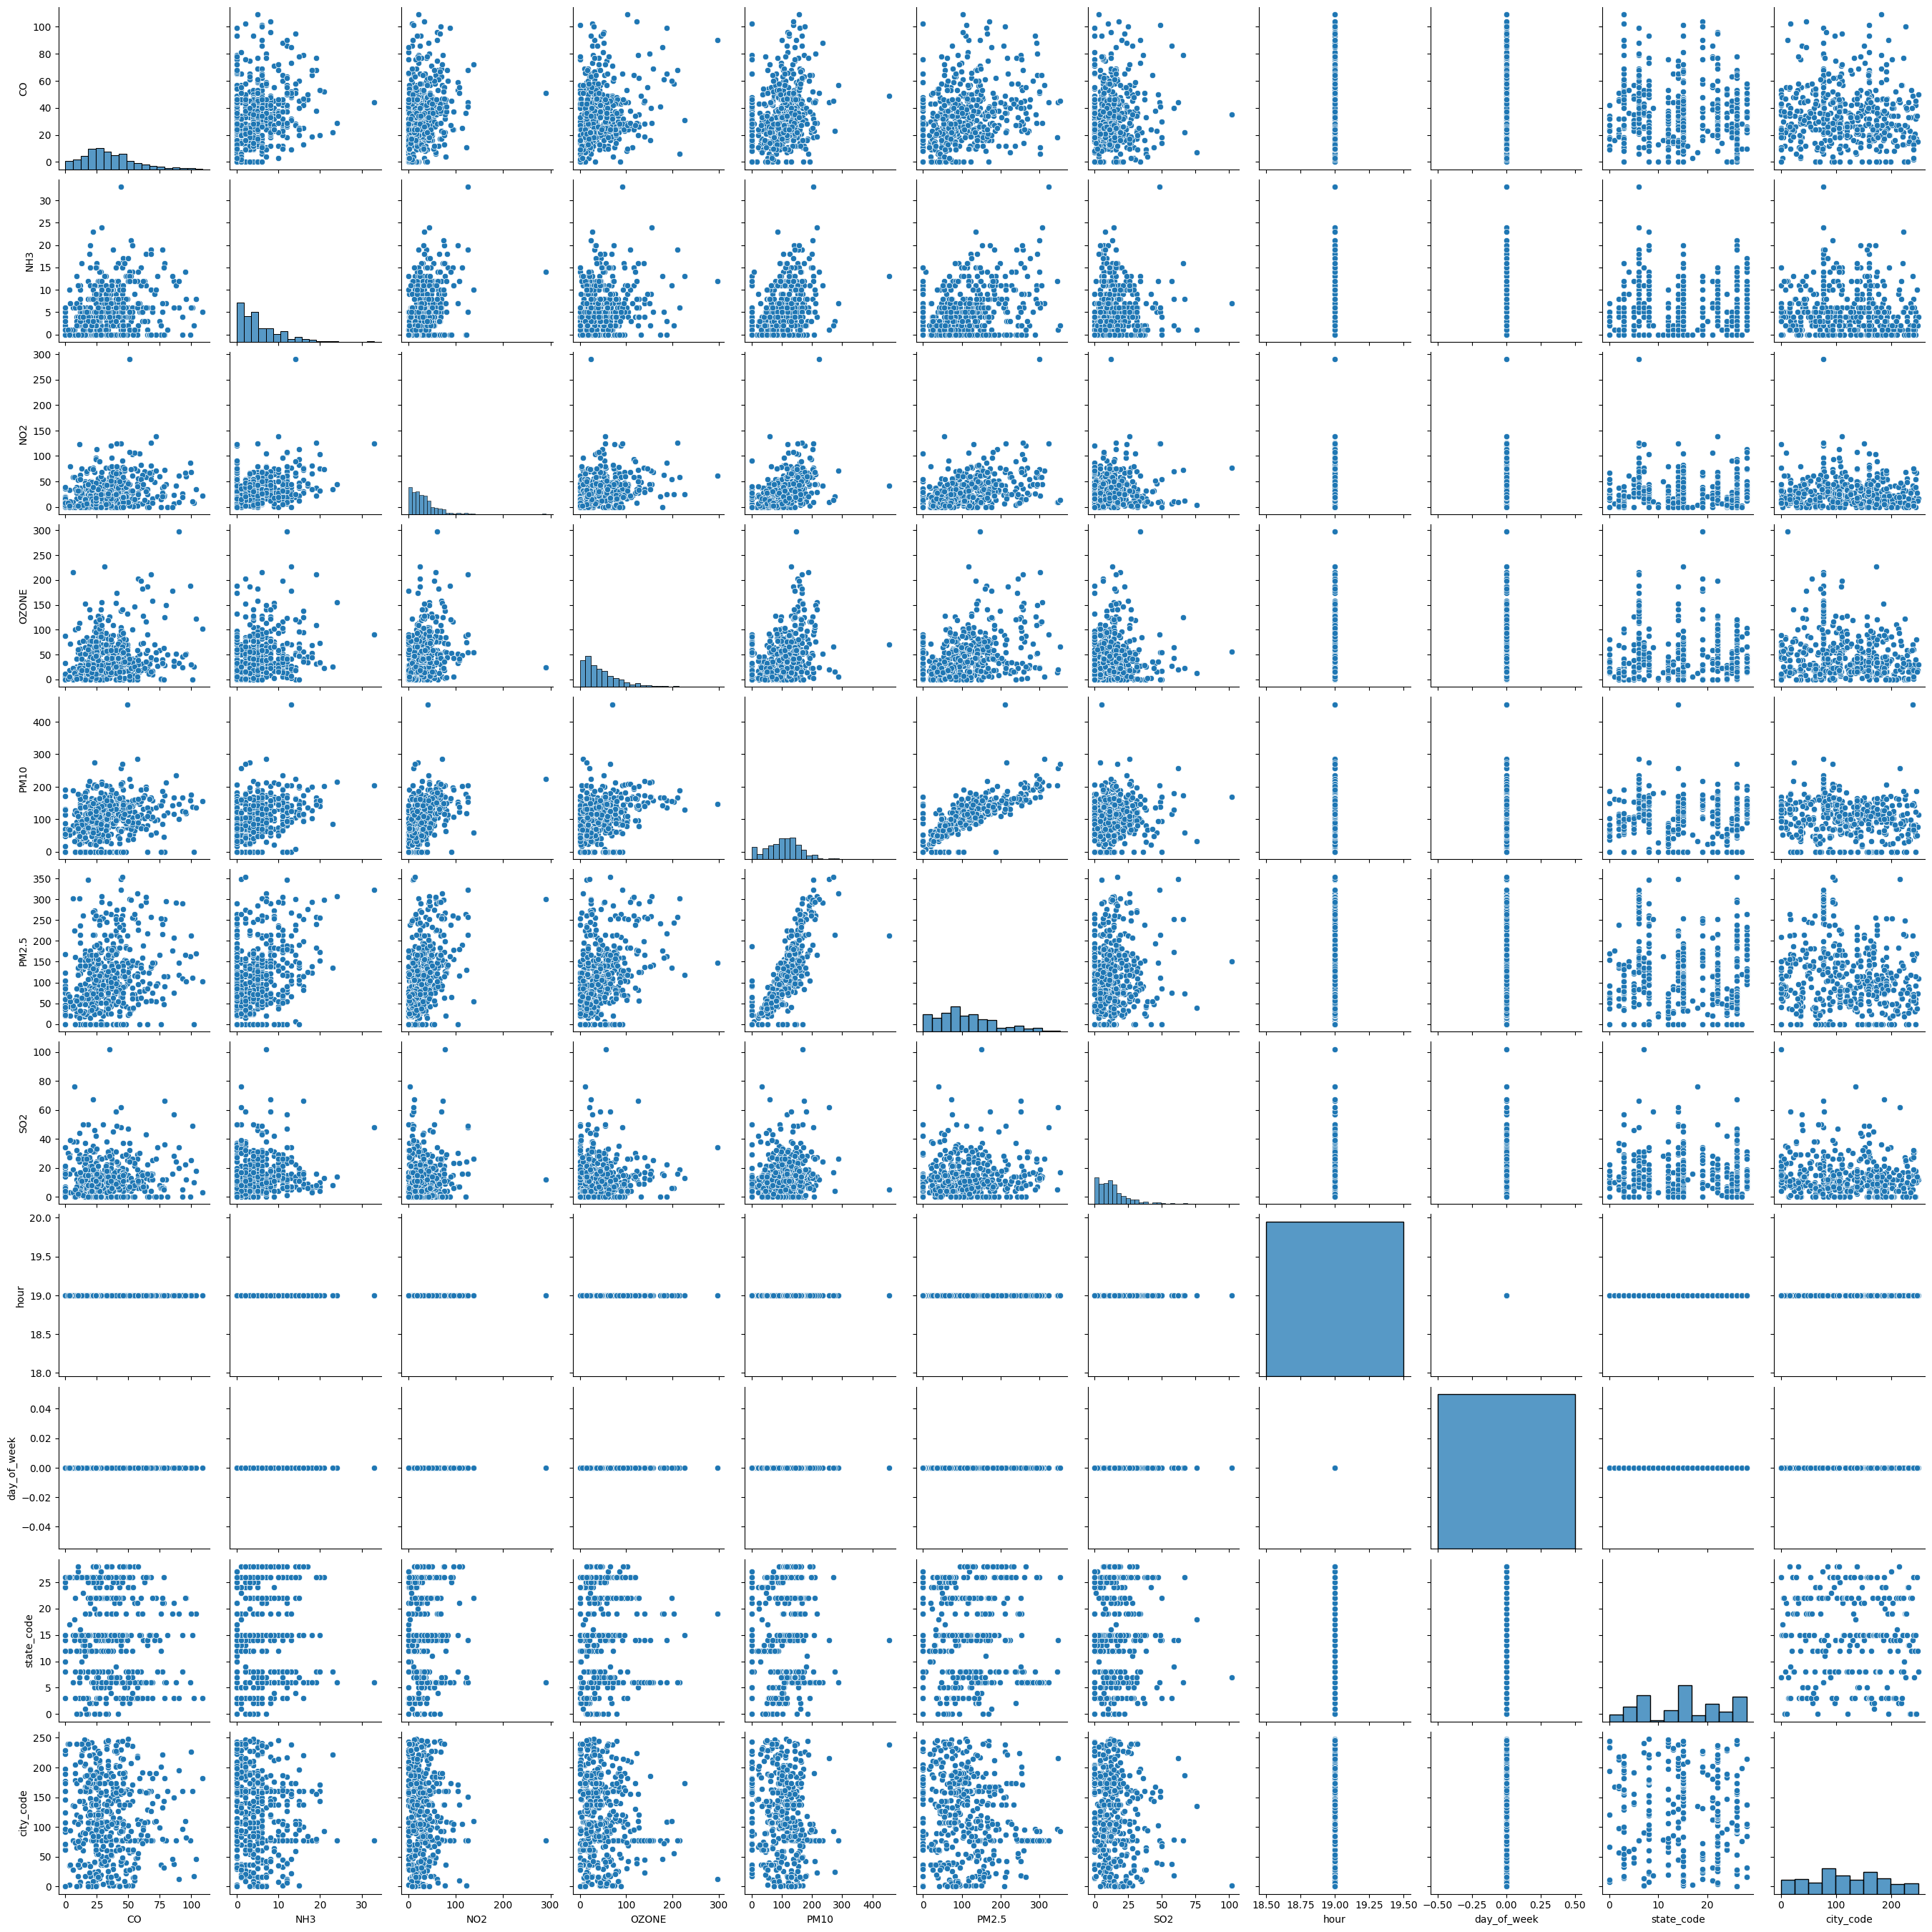

In [10]:
sns.pairplot(data=df_pivot)

In [11]:
df['state'].value_counts()

,count
state,
Maharashtra,561
Uttar_Pradesh,358
Rajasthan,322
Delhi,257
Bihar,223
Haryana,195
Karnataka,189
Madhya Pradesh,167
West_Bengal,154


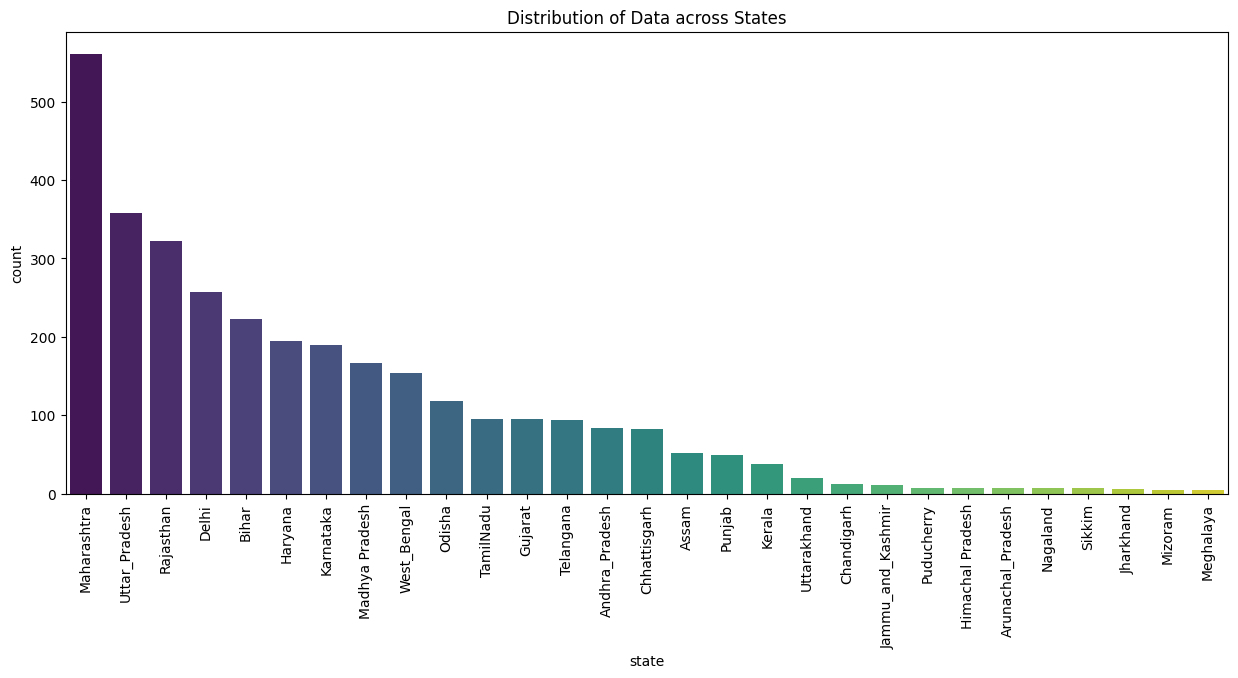

In [12]:
plt.figure(figsize=(15, 6))
# countplot does the counting, sorting, and coloring automatically
sns.countplot(data=df, x='state', order=df['state'].value_counts().index, palette='viridis')
plt.xticks(rotation=90)
plt.title('Distribution of Data across States')
plt.show()

In [14]:
# print every single column name in the original df
print("--- Exact Column Names ---")
print(df.columns.tolist())


--- Exact Column Names ---
['country', 'state', 'city', 'station', 'last_update', 'latitude', 'longitude', 'pollutant_id', 'pollutant_min', 'pollutant_max', 'pollutant_avg']


In [17]:
# 1. Pivot the table correctly (including all features we need)
df_pivot = df.pivot_table(values='pollutant_avg',
                          index=['state', 'city', 'station', 'latitude', 'longitude', 'last_update'],
                          columns='pollutant_id').reset_index()

# 2. Convert 'station' names into numbers (Label Encoding)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_pivot['station_code'] = le.fit_transform(df_pivot['station'])

# 3. Create 'hour' feature from the timestamp
df_pivot['last_update'] = pd.to_datetime(df_pivot['last_update'])
df_pivot['hour'] = df_pivot['last_update'].dt.hour

# 4. Fill any missing pollutant values created by the pivot
df_pivot.fillna(0, inplace=True)


print("--- Features Ready for Model ---")
print(df_pivot[['station_code', 'latitude', 'longitude', 'hour']].head())

--- Features Ready for Model ---
pollutant_id  station_code   latitude  longitude  hour
0                      383  16.515083  80.518167    19
1                      126  14.675886  77.593027    19
2                      112  13.204880  79.097889    19
3                      478  14.465052  78.824187    19
4                        7  16.987287  81.736318    19


In [16]:
from sklearn.preprocessing import LabelEncoder

# 1. Initialize the LabelEncoder
le = LabelEncoder()

# 2. Convert 'station' names into unique numbers
df_pivot['station_code'] = le.fit_transform(df_pivot['station'])

# 3. Handle the 'last_update' column to get time-based features
# This helps the model understand if it's morning or night
df_pivot['last_update'] = pd.to_datetime(df_pivot['last_update'])
df_pivot['hour'] = df_pivot['last_update'].dt.hour

# 4. Preview  new numerical features
print("--- Features Ready for Model ---")
print(df_pivot[['station_code', 'latitude', 'longitude', 'hour']].head())


--- Features Ready for Model ---
pollutant_id  station_code   latitude  longitude  hour
0                      383  16.515083  80.518167    19
1                      126  14.675886  77.593027    19
2                      112  13.204880  79.097889    19
3                      478  14.465052  78.824187    19
4                        7  16.987287  81.736318    19


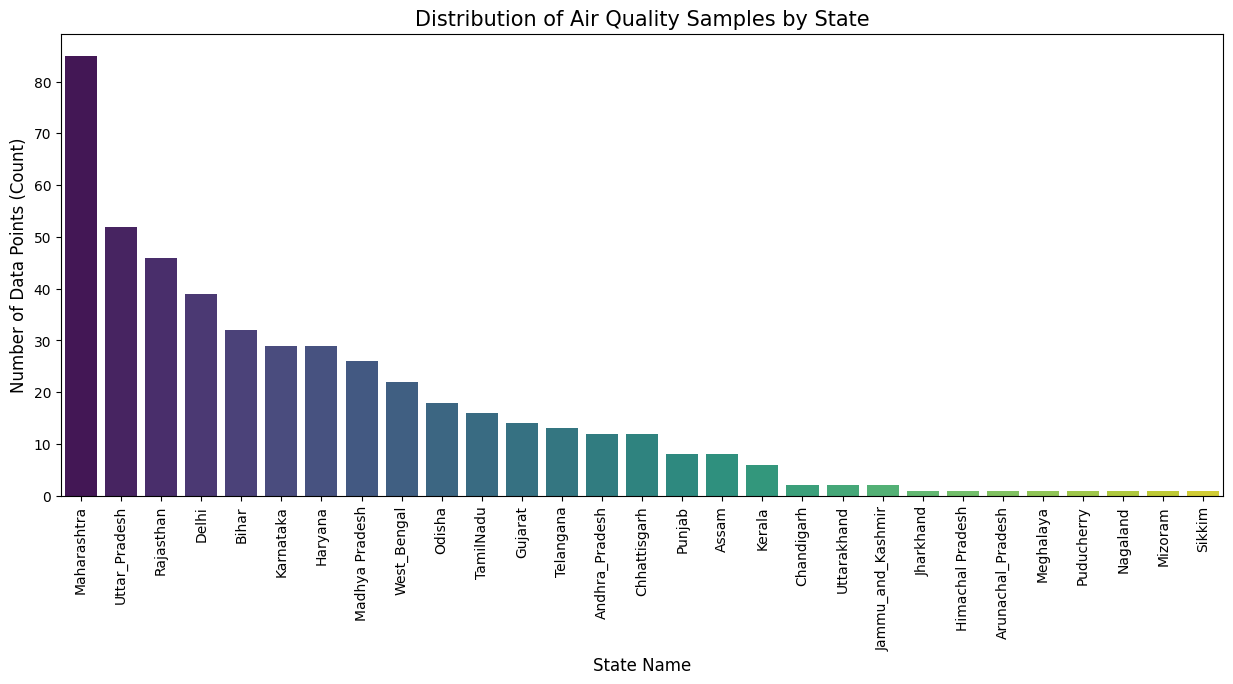

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15, 6))
plt.xticks(rotation=90)
sns.countplot(data=df_pivot, x='state', palette='viridis', order=df_pivot['state'].value_counts().index)

plt.xlabel('State Name', fontsize=12)
plt.ylabel('Number of Data Points (Count)', fontsize=12)
plt.title('Distribution of Air Quality Samples by State', fontsize=15)

plt.show()

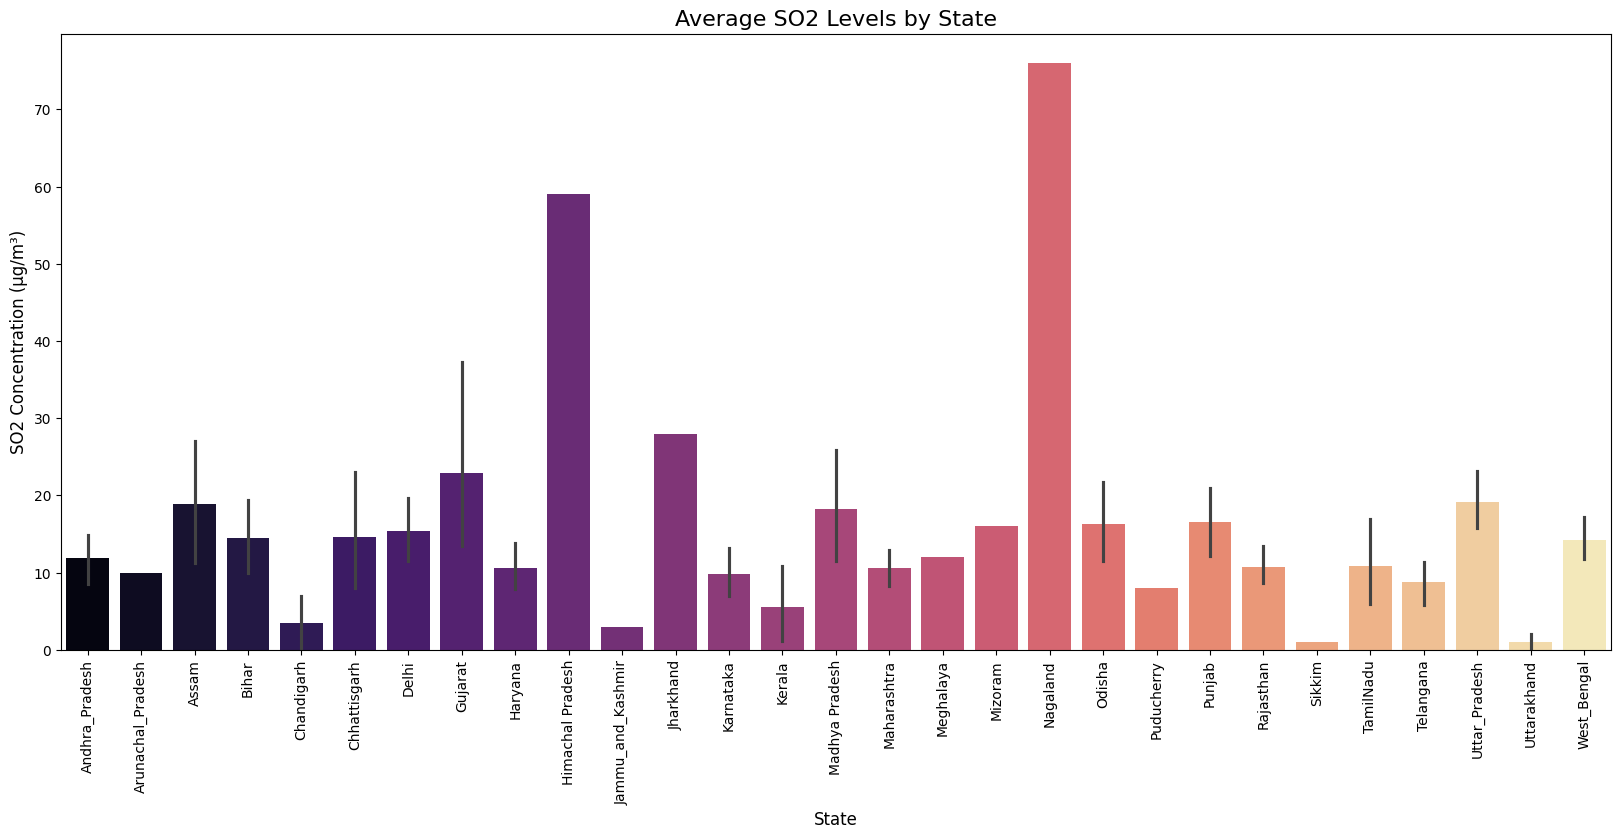

In [19]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation=90)
sns.barplot(x='state', y='SO2', data=df_pivot, palette='magma')
#This visuzlization shows the name of the state having higher so2 levels in the air.

# Professional labeling
plt.title('Average SO2 Levels by State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('SO2 Concentration (µg/m³)', fontsize=12)

plt.show()

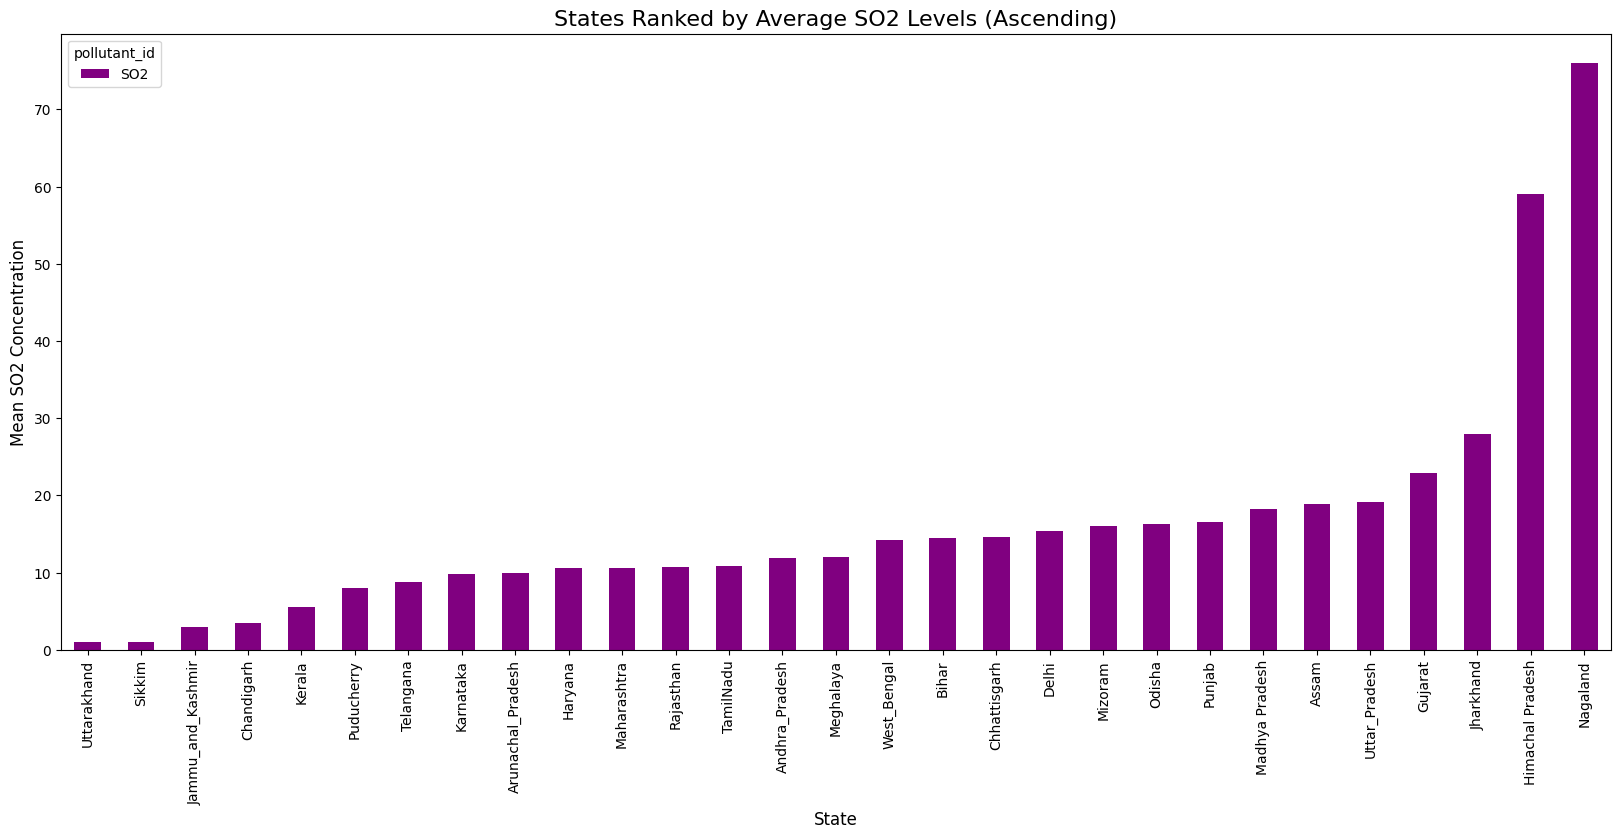

In [20]:
# Group by state, take the mean of SO2, and sort from lowest to highest
state_so2_ranked = df_pivot[['SO2', 'state']].groupby(["state"]).mean().sort_values(by='SO2')

# Plot the data
state_so2_ranked.plot.bar(color='purple', figsize=(20, 8))

# professional labels
plt.title('States Ranked by Average SO2 Levels (Ascending)', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Mean SO2 Concentration', fontsize=12)
plt.xticks(rotation=90)

plt.show()

# Below we got a clear picture of the states in an increasing order based on their so2 levels.

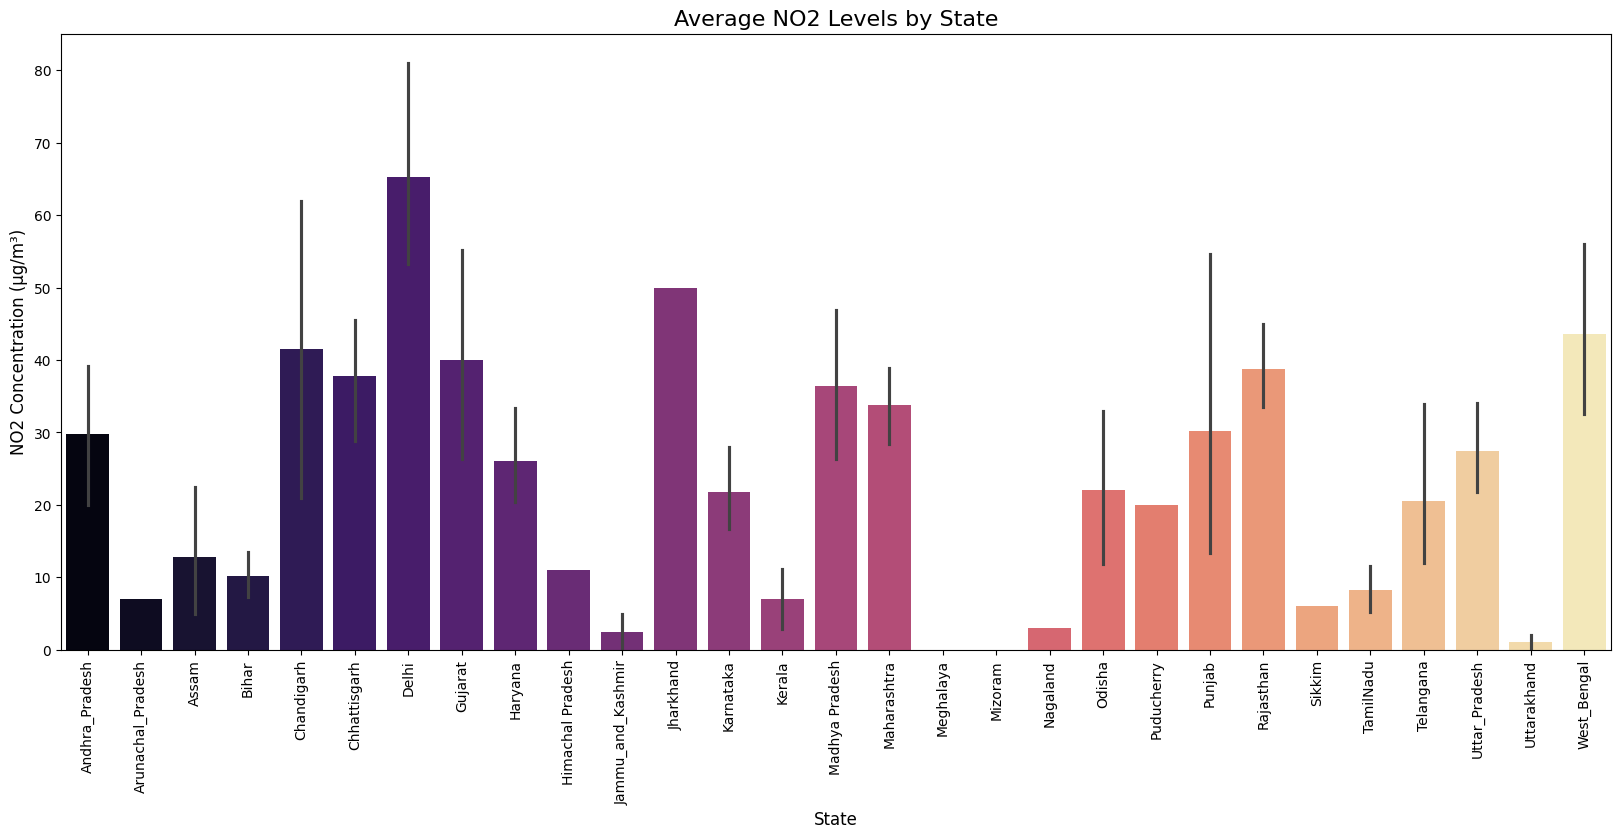

In [21]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation=90)
sns.barplot(x='state', y='NO2', data=df_pivot, palette='magma')
#This visuzlization shows the name of the state having higher no2 levels in the air.

# Professional labeling
plt.title('Average NO2 Levels by State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('NO2 Concentration (µg/m³)', fontsize=12)

plt.show()

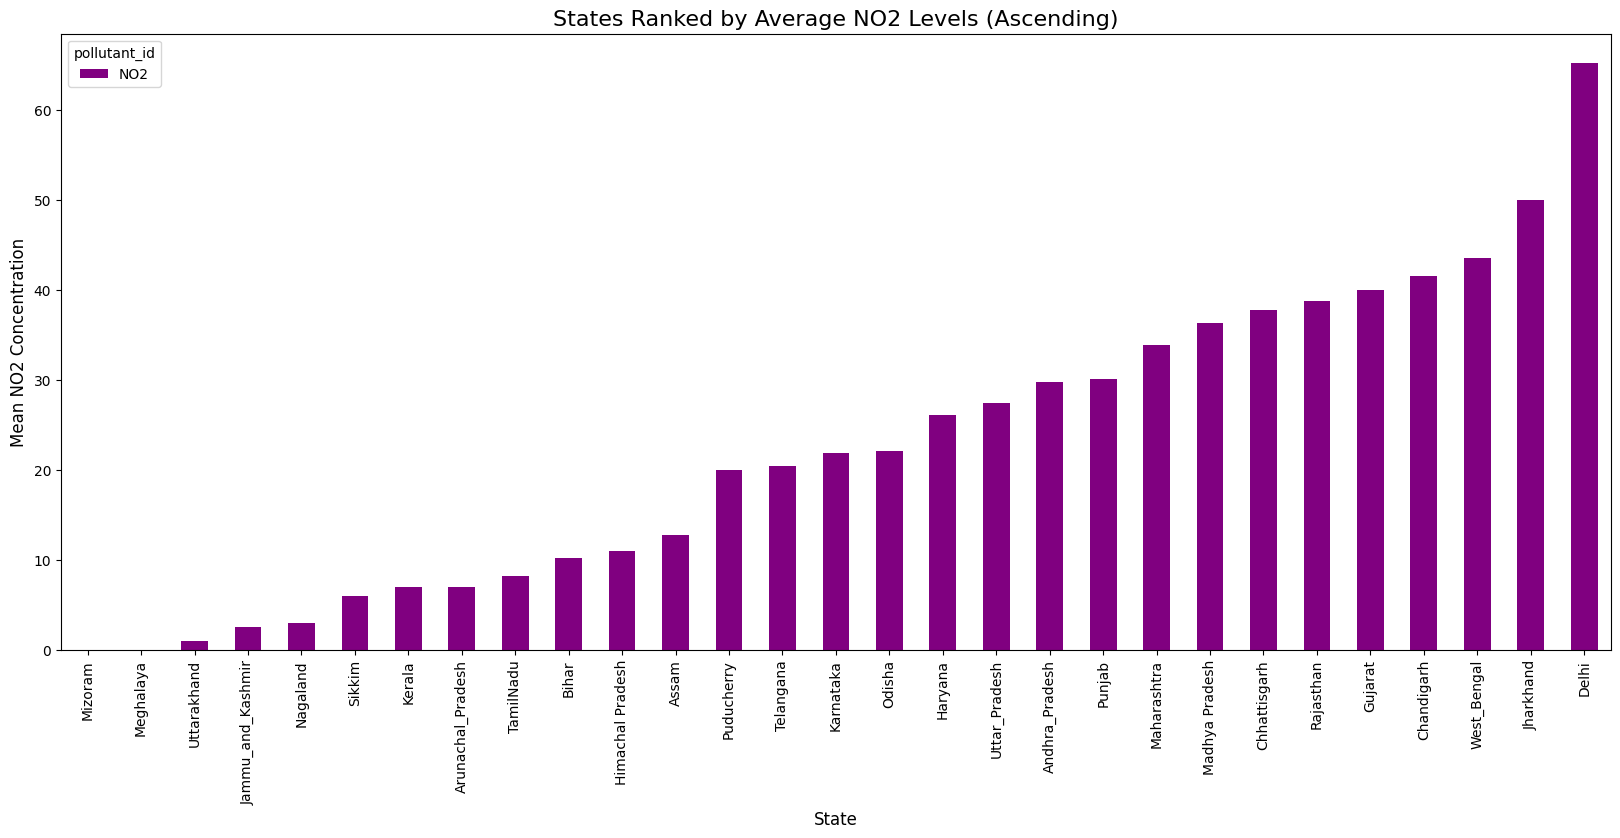

In [22]:
# Group by state, take the mean of NO2, and sort from lowest to highest
state_no2_ranked = df_pivot[['NO2', 'state']].groupby(["state"]).mean().sort_values(by='NO2')

# Plot the data
state_no2_ranked.plot.bar(color='purple', figsize=(20, 8))

# professional labels
plt.title('States Ranked by Average NO2 Levels (Ascending)', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('Mean NO2 Concentration', fontsize=12)
plt.xticks(rotation=90)

plt.show()

# Below we got a clear picture of the states in an increasing order based on their no2 levels.

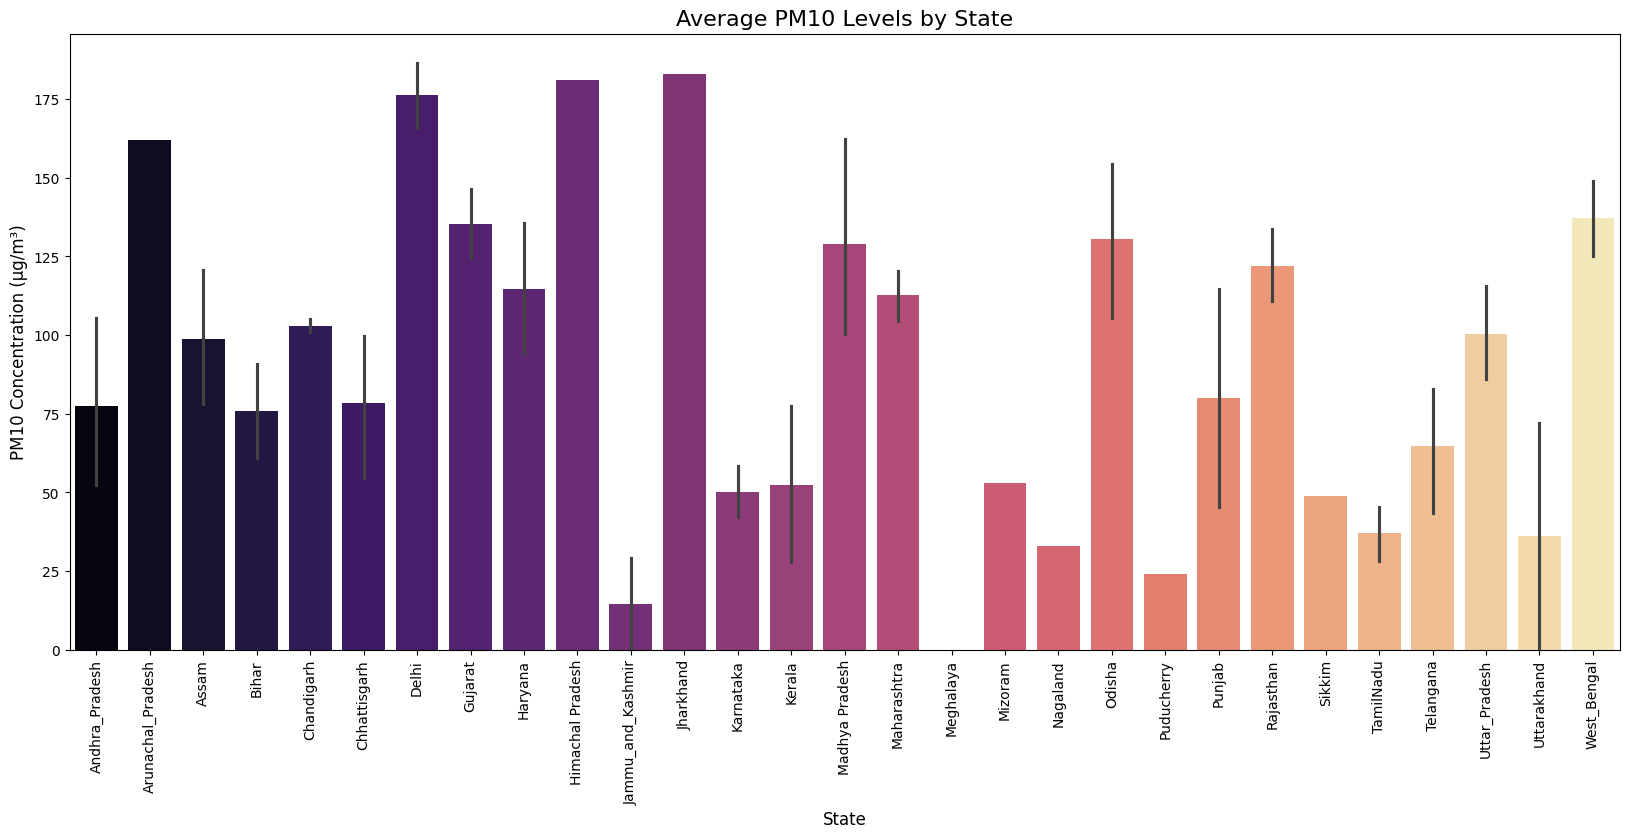

In [23]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation=90)
sns.barplot(x='state', y='PM10', data=df_pivot, palette='magma')
#This visuzlization shows the name of the state having higher PM10 levels in the air.

# Professional labeling
plt.title('Average PM10 Levels by State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('PM10 Concentration (µg/m³)', fontsize=12)

plt.show()

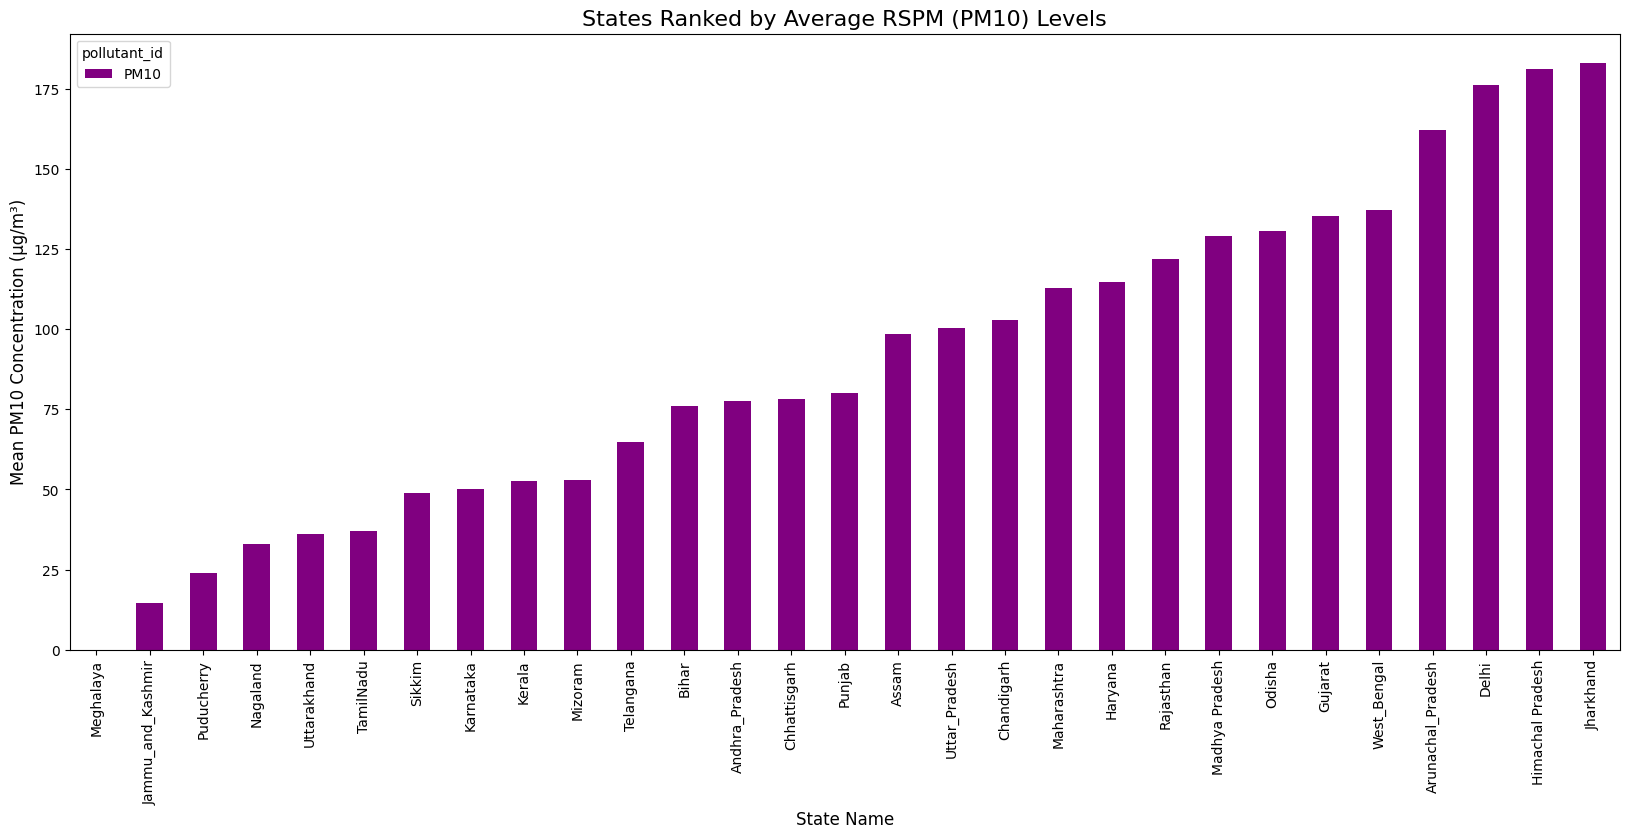

In [24]:
# Group by state and calculate the average PM10 (RSPM)
state_pm10_ranked = df_pivot[['PM10', 'state']].groupby(["state"]).mean().sort_values(by='PM10')

# Plotting the data
state_pm10_ranked.plot.bar(color='purple', figsize=(20, 8))

# Professional Labels
plt.title('States Ranked by Average RSPM (PM10) Levels', fontsize=16)
plt.xlabel('State Name', fontsize=12)
plt.ylabel('Mean PM10 Concentration (µg/m³)', fontsize=12)
plt.xticks(rotation=90)

plt.show()
# Below we got a clear picture of the states in an increasing order based on their PM10 levels.

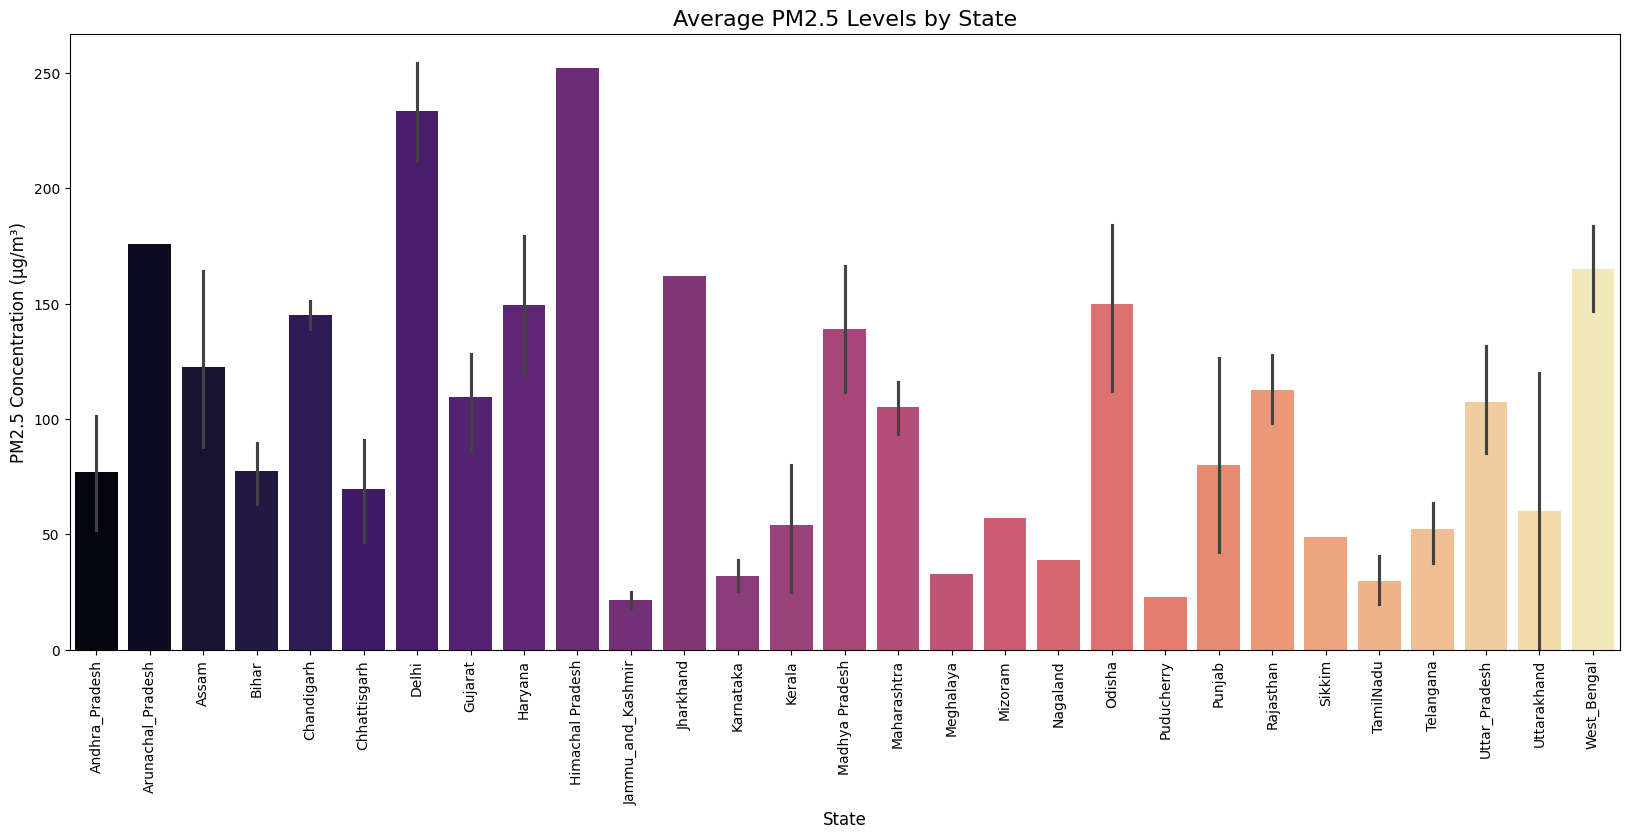

In [25]:
plt.figure(figsize=(20, 8))
plt.xticks(rotation=90)
sns.barplot(x='state', y='PM2.5', data=df_pivot, palette='magma')
#This visuzlization shows the name of the state having higher PM2.5 levels in the air.

# Professional labeling
plt.title('Average PM2.5 Levels by State', fontsize=16)
plt.xlabel('State', fontsize=12)
plt.ylabel('PM2.5 Concentration (µg/m³)', fontsize=12)

plt.show()

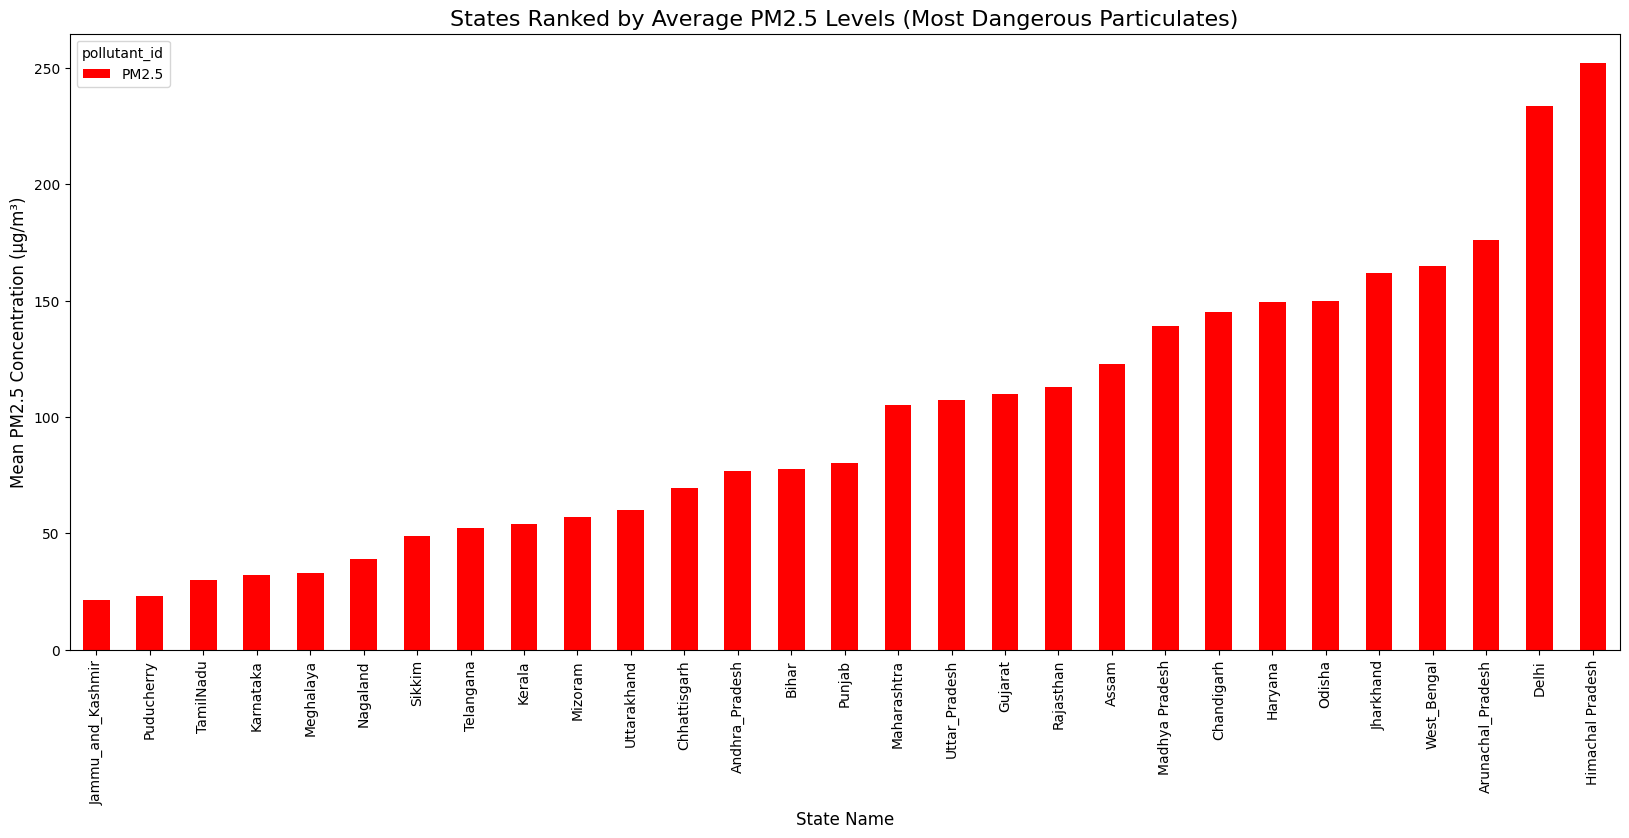

In [26]:
# Group by state and calculate average PM2.5

state_pm25_ranked = df_pivot[['PM2.5', 'state']].groupby(["state"]).mean().sort_values(by='PM2.5')

#  Plotting the data

state_pm25_ranked.plot.bar(color='red', figsize=(20, 8))

#  Professional Labels
plt.title('States Ranked by Average PM2.5 Levels (Most Dangerous Particulates)', fontsize=16)
plt.xlabel('State Name', fontsize=12)
plt.ylabel('Mean PM2.5 Concentration (µg/m³)', fontsize=12)
plt.xticks(rotation=90)

plt.show()

In [27]:
nullvalues = df_pivot.isnull().sum().sort_values(ascending=False)
#Checking all the null values

In [28]:
nullvalues

,0
pollutant_id,
state,0
city,0
station,0
latitude,0
longitude,0
last_update,0
CO,0
NH3,0
NO2,0


In [29]:
#  Calculate the percentage of missing values
null_values_percentage = (df_pivot.isnull().sum() / df_pivot.isnull().count() * 100).sort_values(ascending=False)
#count(return Non-NAN value)

In [30]:
missing_data_with_percentage = pd.concat([nullvalues, null_values_percentage], axis=1, keys=['Total', 'Percent'])
#Concatenating total null values and their percentage of missing values for further imputation or column deletion


In [31]:
print("--- Data Quality Report ---")
print(missing_data_with_percentage)
# These are the percentages of null values present in the dataset.

--- Data Quality Report ---
              Total  Percent
pollutant_id                
state             0      0.0
city              0      0.0
station           0      0.0
latitude          0      0.0
longitude         0      0.0
last_update       0      0.0
CO                0      0.0
NH3               0      0.0
NO2               0      0.0
OZONE             0      0.0
PM10              0      0.0
PM2.5             0      0.0
SO2               0      0.0
station_code      0      0.0
hour              0      0.0


In [32]:
df_pivot.drop(['city', 'station', 'longitude', 'latitude', 'last_update'], axis=1, inplace=True)
#Dropping unnecessary columns

In [33]:
df_pivot.isnull().sum()

,0
pollutant_id,
state,0
CO,0
NH3,0
NO2,0
OZONE,0
PM10,0
PM2.5,0
SO2,0
station_code,0


In [34]:
df_pivot

pollutant_id,state,CO,NH3,NO2,OZONE,PM10,PM2.5,SO2,station_code,hour
0,Andhra_Pradesh,12.0,5.0,20.0,61.0,149.0,155.0,7.0,383,19
1,Andhra_Pradesh,24.0,5.0,14.0,13.0,70.0,68.0,11.0,126,19
2,Andhra_Pradesh,42.0,7.0,47.0,50.0,69.0,75.0,22.0,112,19
3,Andhra_Pradesh,9.0,4.0,28.0,21.0,64.0,64.0,12.0,478,19
4,Andhra_Pradesh,27.0,5.0,26.0,32.0,103.0,93.0,10.0,7,19
...,...,...,...,...,...,...,...,...,...,...
476,West_Bengal,43.0,10.0,50.0,15.0,165.0,234.0,14.0,158,19
477,West_Bengal,51.0,12.0,108.0,41.0,139.0,180.0,7.0,328,19
478,West_Bengal,47.0,16.0,75.0,36.0,116.0,114.0,16.0,329,19
479,West_Bengal,33.0,8.0,43.0,43.0,158.0,203.0,18.0,466,19


Function to calculate SO2 individual pollutant Index

In [35]:
# Define the Function
def cal_SOi(so2):
    si = 0
    if (so2 <= 40):
        si = so2 * (50/40)
    elif (so2 > 40 and so2 <= 80):
        si = 50 + (so2 - 40) * (50/40)
    elif (so2 > 80 and so2 <= 380):
        si = 100 + (so2 - 80) * (100/300)
    elif (so2 > 380 and so2 <= 800):
        si = 200 + (so2 - 380) * (100/420)
    elif (so2 > 800 and so2 <= 1600):
        si = 300 + (so2 - 800) * (100/800)
    elif (so2 > 1600):
        si = 400 + (so2 - 1600) * (100/800)
    return si

# Applying it
df_pivot['SOi'] = df_pivot['SO2'].apply(cal_SOi)

#  result
data = df_pivot[['SO2', 'SOi']]
print(data.head())
# Calculating the individual pollutant index for so2(sulphur dioxide)

pollutant_id   SO2    SOi
0              7.0   8.75
1             11.0  13.75
2             22.0  27.50
3             12.0  15.00
4             10.0  12.50



Function to calculate NO2 individual pollutant Index

In [36]:
# Define the Function for Nitrogen Dioxide
def cal_Noi(no2):
    ni = 0
    if (no2 <= 40):
        ni = no2 * (50/40)
    elif (no2 > 40 and no2 <= 80):
        ni = 50 + (no2 - 40) * (50/40)
    elif (no2 > 80 and no2 <= 180):
        ni = 100 + (no2 - 80) * (100/100)
    elif (no2 > 180 and no2 <= 280):
        ni = 200 + (no2 - 180) * (100/100)
    elif (no2 > 280 and no2 <= 400):
        ni = 300 + (no2 - 280) * (100/120)
    else:
        ni = 400 + (no2 - 400) * (100/120)
    return ni

#  Applying it
df_pivot['Noi'] = df_pivot['NO2'].apply(cal_Noi)

data_no2 = df_pivot[['NO2', 'Noi']]
print(data_no2.head())
# Calculating the individual pollutant index for no2(nitrogen dioxide)

pollutant_id   NO2    Noi
0             20.0  25.00
1             14.0  17.50
2             47.0  58.75
3             28.0  35.00
4             26.0  32.50


Function to calculate PM10 individual pollutant Index

In [37]:
# Define the Function for RSPM (PM10)
def cal_RPI(pm10):
    rpi = 0
    if (pm10 <= 30):
        rpi = pm10 * (50/30)
    elif (pm10 > 30 and pm10 <= 60):
        rpi = 50 + (pm10 - 30) * (50/30)
    elif (pm10 > 60 and pm10 <= 90):
        rpi = 100 + (pm10 - 60) * (100/30)
    elif (pm10 > 90 and pm10 <= 120):
        rpi = 200 + (pm10 - 90) * (100/30)
    elif (pm10 > 120 and pm10 <= 250):
        rpi = 300 + (pm10 - 120) * (100/130)
    else:
        rpi = 400 + (pm10 - 250) * (100/130)
    return rpi

# Applying it
df_pivot['Rpi'] = df_pivot['PM10'].apply(cal_RPI)

#  result
data_rpi = df_pivot[['PM10', 'Rpi']]
print(data_rpi.head())
# Calculating the individual pullutant index for PM10 (Particulate Matter 10 micrometers)

pollutant_id   PM10         Rpi
0             149.0  322.307692
1              70.0  133.333333
2              69.0  130.000000
3              64.0  113.333333
4             103.0  243.333333



Function to calculate PM2.5 individual pollutant Index

In [38]:
# Define the Function for SPM (using PM2.5 data)
def cal_SPMi(pm25):
    spi = 0
    if (pm25 <= 50):
        spi = pm25 * (50/50)
    elif (pm25 > 50 and pm25 <= 100):
        spi = 50 + (pm25 - 50) * (50/50)
    elif (pm25 > 100 and pm25 <= 250):
        spi = 100 + (pm25 - 100) * (100/150)
    elif (pm25 > 250 and pm25 <= 350):
        spi = 200 + (pm25 - 250) * (100/100)
    elif (pm25 > 350 and pm25 <= 430):
        spi = 300 + (pm25 - 350) * (100/80)
    else:
        spi = 400 + (pm25 - 430) * (100/430)
    return spi

#  Applying it
df_pivot['SPMi'] = df_pivot['PM2.5'].apply(cal_SPMi)


data_spmi = df_pivot[['PM2.5', 'SPMi']]
print(data_spmi.head())
# Calculating the individual pollutant index for PM2.5 (Particulate Matter 2.5 micrometers)

pollutant_id  PM2.5        SPMi
0             155.0  136.666667
1              68.0   68.000000
2              75.0   75.000000
3              64.0   64.000000
4              93.0   93.000000


Function to calculate Air Quality Index (AQI) of every data value

In [39]:
# Define the AQI function
# This function simply picks the highest score among the four indices
def cal_aqi(si, ni, rspmi, spmi):
    aqi = max(si, ni, rspmi, spmi)
    return aqi

# Applying it to the table
# We use a 'lambda' to pass all four columns into the function at once
df_pivot['AQI'] = df_pivot.apply(lambda x: cal_aqi(x['SOi'], x['Noi'], x['Rpi'], x['SPMi']), axis=1)

# final results
data_final = df_pivot[['state', 'SOi', 'Noi', 'Rpi', 'SPMi', 'AQI']]
print("--- Final AQI Calculated ---")
print(data_final.head())
# Calculating the Air Quality Index.

--- Final AQI Calculated ---
pollutant_id           state    SOi    Noi         Rpi        SPMi         AQI
0             Andhra_Pradesh   8.75  25.00  322.307692  136.666667  322.307692
1             Andhra_Pradesh  13.75  17.50  133.333333   68.000000  133.333333
2             Andhra_Pradesh  27.50  58.75  130.000000   75.000000  130.000000
3             Andhra_Pradesh  15.00  35.00  113.333333   64.000000  113.333333
4             Andhra_Pradesh  12.50  32.50  243.333333   93.000000  243.333333


In [40]:
# Define the Range Function
def AQI_Range(x):
    if x <= 50:
        return "Good"
    elif x > 50 and x <= 100:
        return "Moderate"
    elif x > 100 and x <= 200:
        return "Poor"
    elif x > 200 and x <= 300:
        return "Unhealthy"
    elif x > 300 and x <= 400:
        return "Very unhealthy"
    elif x > 400:
        return "Hazardous"

# Applying it to the AQI column
df_pivot['AQI_Range'] = df_pivot['AQI'].apply(AQI_Range)

# Viewing the classified results
print("--- AQI Classification Complete ---")
print(df_pivot[['state', 'AQI', 'AQI_Range']].head())

--- AQI Classification Complete ---
pollutant_id           state         AQI       AQI_Range
0             Andhra_Pradesh  322.307692  Very unhealthy
1             Andhra_Pradesh  133.333333            Poor
2             Andhra_Pradesh  130.000000            Poor
3             Andhra_Pradesh  113.333333            Poor
4             Andhra_Pradesh  243.333333       Unhealthy


In [41]:
# Counting how many times each category appears
print("--- AQI Category Summary ---")
print(df_pivot['AQI_Range'].value_counts())

--- AQI Category Summary ---
AQI_Range
Very unhealthy    190
Unhealthy         108
Poor               85
Moderate           56
Good               37
Hazardous           5
Name: count, dtype: int64


Splitting the dataset into Dependent and Independent columns

In [42]:
# Select the columns that help predict AQI (Independent Variables)
X = df_pivot[['SOi', 'Noi', 'Rpi', 'SPMi']]

# Select the final AQI column we want to predict (Dependent Variable)
Y = df_pivot['AQI']

# Independent columns
print("--- Features (X) ---")
print(X.head())

# Dependent columns
print("\n--- Target (Y) ---")
print(Y.head())

--- Features (X) ---
pollutant_id    SOi    Noi         Rpi        SPMi
0              8.75  25.00  322.307692  136.666667
1             13.75  17.50  133.333333   68.000000
2             27.50  58.75  130.000000   75.000000
3             15.00  35.00  113.333333   64.000000
4             12.50  32.50  243.333333   93.000000

--- Target (Y) ---
0    322.307692
1    133.333333
2    130.000000
3    113.333333
4    243.333333
Name: AQI, dtype: float64


In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=70)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
# Splitting the data into training and testing data

(384, 4) (97, 4) (384,) (97,)


Linear Regression

In [44]:
# Initialize and Train the model
model = LinearRegression()
model.fit(X_train, Y_train)

# Predicting train
train_pred = model.predict(X_train)
# Predicting on test
test_pred = model.predict(X_test)

print("--- Training Complete ---")

--- Training Complete ---


In [45]:
# Calculating
RMSE_train = np.sqrt(metrics.mean_squared_error(Y_train, train_pred))
RMSE_test = np.sqrt(metrics.mean_squared_error(Y_test, test_pred))

print(f"RMSE Training Data = {RMSE_train}")
print(f"RMSE Test Data = {RMSE_test}")
print('-' * 50)
print(f"RSquared value on train: {model.score(X_train, Y_train)}")
print(f"RSquared value on test: {model.score(X_test, Y_test)}")

RMSE Training Data = 13.42042927834991
RMSE Test Data = 7.444094390026774
--------------------------------------------------
RSquared value on train: 0.9855574837314484
RSquared value on test: 0.994388349046978


Decision Tree Regressor

In [46]:
# Initialize and Train the Decision Tree
DT = DecisionTreeRegressor()
DT.fit(X_train, Y_train)

# Predicting train
train_preds = DT.predict(X_train)
# Predicting on test
test_preds = DT.predict(X_test)

In [47]:
# Calculating
RMSE_train_dt = np.sqrt(metrics.mean_squared_error(Y_train, train_preds))
RMSE_test_dt = np.sqrt(metrics.mean_squared_error(Y_test, test_preds))

print(f"RMSE Training Data = {RMSE_train_dt}")
print(f"RMSE Test Data = {RMSE_test_dt}")
print('-' * 50)
print(f"RSquared value on train: {DT.score(X_train, Y_train)}")
print(f"RSquared value on test: {DT.score(X_test, Y_test)}")

RMSE Training Data = 8.457150154752983e-15
RMSE Test Data = 11.37801011028251
--------------------------------------------------
RSquared value on train: 1.0
RSquared value on test: 0.9868900951994571


Random Forest Regressor

In [48]:
# Initialize and Train the Random Forest
RF = RandomForestRegressor()
RF.fit(X_train, Y_train)

# Predicting train
train_preds1 = RF.predict(X_train)
# Predicting on test
test_preds1 = RF.predict(X_test)

In [49]:
# Calculating
RMSE_train = (np.sqrt(metrics.mean_squared_error(Y_train, train_preds1)))
RMSE_test = (np.sqrt(metrics.mean_squared_error(Y_test, test_preds1)))
print(f"RMSE TrainingData = {RMSE_train}")
print(f"RMSE TestData = {RMSE_test}")
print('-' * 50)
print(f"RSquared value on train: {RF.score(X_train, Y_train)}")
print(f"RSquared value on test: {RF.score(X_test, Y_test)}")

RMSE TrainingData = 3.6256278043523933
RMSE TestData = 5.491711636745552
--------------------------------------------------
RSquared value on train: 0.9989459129270926
RSquared value on test: 0.9969459063003563


Classification Algorithms

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score

In [51]:
# Independent variables
X2 = df_pivot[['SOi', 'Noi', 'Rpi', 'SPMi']]

# Dependent variable
Y2 = df_pivot['AQI_Range']

In [52]:
# Splitting the data
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.33, random_state=70)

print(f"Classification Training Set: {X_train2.shape}")
print(f"Classification Testing Set: {X_test2.shape}")

Classification Training Set: (322, 4)
Classification Testing Set: (159, 4)


Logistic Regression

In [53]:
# Initialize and Train the model
log_reg = LogisticRegression()
log_reg.fit(X_train2, Y_train2)

# Predicting on train
train_preds2 = log_reg.predict(X_train2)
# accuracy on train
print(f"Model accuracy on train is: {accuracy_score(Y_train2, train_preds2)}")

# Predicting on test
test_preds2 = log_reg.predict(X_test2)
# accuracy on test
print(f"Model accuracy on test is: {accuracy_score(Y_test2, test_preds2)}")
print('-' * 50)

# Kappa Score
print(f"KappaScore is: {cohen_kappa_score(Y_test2, test_preds2)}")

Model accuracy on train is: 0.531055900621118
Model accuracy on test is: 0.4339622641509434
--------------------------------------------------
KappaScore is: 0.15917503966155488


In [54]:
log_reg.predict([[727, 327.55, 78.2, 100]])

array(['Good'], dtype=object)

In [55]:
log_reg.predict([[2.7, 45, 35.16, 23]])

array(['Moderate'], dtype=object)

In [56]:
log_reg.predict([[10, 2.8, 82, 20]])

array(['Very unhealthy'], dtype=object)

In [57]:
log_reg.predict([[2, 45.8, 37, 32]])

array(['Moderate'], dtype=object)

Decision Tree Classifier

In [58]:
# Initialize and Fit the model on training data
DT2 = DecisionTreeClassifier()
DT2.fit(X_train2, Y_train2)

# Predict on train
train_preds3 = DT2.predict(X_train2)
# accuracy on train
print(f"Model accuracy on train is: {accuracy_score(Y_train2, train_preds3)}")

# Predict on test
test_preds3 = DT2.predict(X_test2)
# accuracy on test
print(f"Model accuracy on test is: {accuracy_score(Y_test2, test_preds3)}")
print('-' * 50)

# Kappa Score
print(f"KappaScore is: {cohen_kappa_score(Y_test2, test_preds3)}")

Model accuracy on train is: 1.0
Model accuracy on test is: 0.9874213836477987
--------------------------------------------------
KappaScore is: 0.9830616810482582


Random Forest Classifier

In [59]:
# Initialize and Train the model
RF2 = RandomForestClassifier()
RF2.fit(X_train2, Y_train2)

# Predict on train
train_preds4 = RF2.predict(X_train2)
# accuracy on train
print(f"Model accuracy on train is: {accuracy_score(Y_train2, train_preds4)}")

# Predict on test
test_preds4 = RF2.predict(X_test2)
# accuracy on test
print(f"Model accuracy on test is: {accuracy_score(Y_test2, test_preds4)}")
print('-' * 50)

# Kappa Score
print(f"KappaScore is: {cohen_kappa_score(Y_test2, test_preds4)}")

Model accuracy on train is: 1.0
Model accuracy on test is: 0.9811320754716981
--------------------------------------------------
KappaScore is: 0.9745178695443133


K-Nearest Neighbors

In [60]:
# Initialize and Train the model
KNN = KNeighborsClassifier()
KNN.fit(X_train2, Y_train2)

# Predict on train
train_preds5 = KNN.predict(X_train2)
# accuracy on train
print(f"Model accuracy on train is: {accuracy_score(Y_train2, train_preds5)}")


# Predict on test
test_preds5 = KNN.predict(X_test2)
# accuracy on test
print(f"Model accuracy on test is: {accuracy_score(Y_test2, test_preds5)}")
print('-' * 50)

# Kappa Score
print(f"KappaScore is: {cohen_kappa_score(Y_test2, test_preds5)}")

Model accuracy on train is: 0.937888198757764
Model accuracy on test is: 0.9245283018867925
--------------------------------------------------
KappaScore is: 0.8974193548387097


In [61]:
KNN.predict([[7.4, 47.7, 78.182, 100]])
# Prediction on random values

array(['Moderate'], dtype=object)

In [62]:
KNN.predict([[1, 1.2, 3.12, 0]])
# Prediction on random values

array(['Good'], dtype=object)

In [63]:
KNN.predict([[325.7, 345, 798.182, 203]])
# Prediction on random values

array(['Very unhealthy'], dtype=object)

In [64]:
import joblib
# We use RF2 because that was your Random Forest Classifier
joblib.dump(RF2, 'aqi_model.pkl')
print("Success: aqi_model.pkl created!")

Success: aqi_model.pkl created!
